In [1]:
import numpy as np

from keras.models import Sequential  
from keras.layers import Dense, Dropout, Activation, Flatten  
from keras.layers import Convolution2D, MaxPooling2D,BatchNormalization
from keras.optimizers import SGD
from keras.utils import np_utils
from scipy import misc
import glob
import matplotlib.pyplot as plt
from PIL import Image
import math
from skimage.color import rgb2gray

Using TensorFlow backend.


In [2]:
def get_pixel_values():
#     file_name = r''
    pixels = []
    cnt = 0
    for filename in glob.glob('aapl/'+'\*.png'):
        im = misc.imread(filename)
        pixels.append(im)
        cnt+=1
    print(cnt)
    return pixels
def convert_image():
#     file_name = r'\figures_v2'
    for filename in glob.glob('aapl/' + '\*.png'):
        img = Image.open(filename)
#         img = rgb2gray(img);
        img = img.convert('RGB')
        img.save(filename)
convert_image()
pixel_values = np.asarray(get_pixel_values())

498


C:\Users\smadh\Anaconda3\envs\keras-gpu\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


In [3]:
pixel_values.shape

(498, 100, 100, 3)

In [38]:
import requests
import pandas as pd
import arrow
import datetime
from datetime import timezone
import os
import quandl
import numpy as np
from mpl_finance import candlestick_ohlc
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def get_quote_data(symbol='AAPL', data_range='2y', data_interval='1h'):
    res = requests.get('https://query1.finance.yahoo.com/v8/finance/chart/{symbol}?range={data_range}&interval={data_interval}'.format(**locals()))
    data = res.json()
    body = data['chart']['result'][0]    
    dt = datetime.datetime

    dt = pd.Series(map(lambda x: arrow.get(x).datetime.replace(tzinfo=None), body['timestamp']), name='Datetime')
    df = pd.DataFrame(body['indicators']['quote'][0], index=dt)
    dg = pd.DataFrame(body['timestamp'])    
    df = df.loc[:, ('open', 'high', 'low', 'close', 'volume')]
    df.dropna(inplace=True)     #removing NaN rows
    df.columns = ['OPEN', 'HIGH','LOW','CLOSE','VOLUME']    #Renaming columns in pandas

    return df

In [39]:
final_df = get_quote_data('AMZN')
final_df['Ticker'] = 'AMZN'
# list_of_tickers = ['GOOGL','MSFT','AMZN','FB','BABA','JNJ','JPM','BAC','WMT']
# for ticker in list_of_tickers:
#     stock_df = get_quote_data(symbol=ticker)
#     stock_df['Ticker'] = ticker
#     final_df = pd.concat([final_df,stock_df])
final_df.head()

,OPEN,HIGH,LOW,CLOSE,VOLUME,Ticker
Datetime,,,,,,
2017-12-11 14:30:00,1164.310059,1169.719971,1162.979980,1165.589966,628375.0,AMZN
2017-12-11 15:30:00,1165.459961,1166.869995,1157.199951,1162.399902,367769.0,AMZN
2017-12-11 16:30:00,1162.010010,1166.359985,1161.550049,1165.310059,220343.0,AMZN
2017-12-11 17:30:00,1165.640015,1168.880005,1165.395874,1167.069946,209041.0,AMZN
2017-12-11 18:30:00,1167.260010,1168.598022,1166.232056,1166.869995,172242.0,AMZN


In [7]:
final_df.shape

(3492, 6)

In [8]:
import math
count = 0
y_10_days_prediction = []
pixel_index = 0
returns = []
pred = []

try:
    for index, row in final_df.iterrows():
        if((count-1)%7==0):

            row1 = final_df.iloc[[count+10]]
    #         print("hey",np.array(row1['OPEN'])[0]/np.array(row['OPEN']))
#             y_10_days_prediction.append(np.array(row1["OPEN"])[0])

            y_10_days_prediction.append((np.array(row1["OPEN"])[0])/(np.array(row['OPEN'])))
            returns.append(row['OPEN'])
            pred.append(np.array(row1["OPEN"])[0])
        count+=1
except:
    pass


In [10]:
len(pred)

498

In [11]:
pixel_values = pixel_values[0:len(y_10_days_prediction)]
print(len(pixel_values))
print(len(y_10_days_prediction))

498
498


In [12]:
size = 400
x_train = pixel_values[0:size]
y_train = np.asarray(y_10_days_prediction[0:size])
y_train_out = np.asarray(returns[0:size])
y_train_pred = np.asarray(pred[0:size])
x_test = pixel_values[size:]
y_test = np.asarray(y_10_days_prediction[size:])
y_test_out = np.asarray(returns[size:])
y_test_pred = np.asarray(pred[size:])
#    y_true = y_test
#    y_train = np_utils.to_categorical(y_train, 2)
#    y_test = np_utils.to_categorical(y_test, 2)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

In [13]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(400, 100, 100, 3) (400,) (98, 100, 100, 3) (98,)


In [14]:
len(returns)

498

In [15]:
def create_model():
    model = Sequential()

    model.add(Convolution2D(32, 3, 3,
                            border_mode='valid', 
                            input_shape=(100, 100, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))  

    model.add(Convolution2D(32, 3, 3)) 
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(Convolution2D(32, 3, 3)) 
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))  
#     model.add(Dropout(0.25))  
    
    
    model.add(Convolution2D(64, 3, 3)) 
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(Convolution2D(64, 3, 3)) 
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(Convolution2D(64, 3, 3)) 
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))  
#     model.add(Dropout(0.25))  
      
    
    model.add(Convolution2D(128, 3, 3)) 
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(Convolution2D(128, 3, 3)) 
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(Convolution2D(128, 3, 3)) 
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))     
    
#     model.add(Dropout(0.2)) 
    model.add(Convolution2D(128,1, 1)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))  


#     model.add(Dropout(0.2)) 
    model.add(Convolution2D(32,1, 1)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))  
    model.add(Flatten())
    model.add(Dense(512))  
    model.add(Activation("relu"))
    model.add(Dense(256))  
    model.add(Activation("relu"))
    model.add(Dense(64))  
    model.add(Activation("relu"))
    model.add(Dense(1))  

    
    
#     model.add(Convolution2D(64, 3, 3, 
#                             border_mode='valid'))  
#     model.add(Activation('relu'))  
#     model.add(Convolution2D(64, 3, 3))  
#     model.add(Activation('relu'))  
#     model.add(MaxPooling2D(pool_size=(2, 2)))  
#     model.add(Dropout(0.25))  
      
#     model.add(Flatten())  
#     model.add(Dense(256))  
#     model.add(Activation('relu'))  
#     model.add(Dropout(0.5))

#     model.add(Dense(1))  
#     model.add(Activation('linear'))  

    return model
def compile_model(model):
    lrate = 0.01
    sgd = SGD(lr=lrate, momentum=0.9, decay=1e-6, nesterov=True)
    model.compile(loss='mse', optimizer='sgd')
    return model

In [16]:
print(x_train.shape)

(400, 100, 100, 3)


In [17]:
print(y_train.shape)

(400,)


In [18]:
model = create_model()
model = compile_model(model)

W1208 13:48:32.214009 17268 module_wrapper.py:139] From C:\Users\smadh\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

C:\Users\smadh\Anaconda3\envs\keras-gpu\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(100, 100,..., padding="valid")`
  
W1208 13:48:32.215007 17268 module_wrapper.py:139] From C:\Users\smadh\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1208 13:48:32.217999 17268 module_wrapper.py:139] From C:\Users\smadh\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1208 13:48:32.246921 17268 module_wrapper.py:139] From C:\Use

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 98, 98, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 94, 94, 32)        9248      
__________

In [86]:
def r_squared(y_true, y_hat):
    ssr = 0
    sst = 0
    e = np.subtract(y_true, y_hat)
    y_mean = np.mean(y_true)
    for item in e:
        ssr += item**2
    for item in y_true:
        sst += (item - y_mean)**2
    r2 = 1 - ssr / sst
    return r2

In [20]:
# Fit the model
epochs = 10
model.fit(x_train, y_train, validation_data=(x_test, y_test), 
          nb_epoch=epochs,
          shuffle=True, batch_size=100, verbose=1)

C:\Users\smadh\Anaconda3\envs\keras-gpu\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """
W1208 13:48:41.671484 17268 module_wrapper.py:139] From C:\Users\smadh\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1208 13:48:41.825074 17268 module_wrapper.py:139] From C:\Users\smadh\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 400 samples, validate on 98 samples
Epoch 1/10
400/400 [==============================] - 19s 48ms/step - loss: 1.9575 - val_loss: 0.3562
Epoch 2/10
400/400 [==============================] - 19s 46ms/step - loss: 0.0553 - val_loss: 0.0491
Epoch 3/10
400/400 [==============================] - 18s 45ms/step - loss: 0.0213 - val_loss: 0.0382
Epoch 4/10
400/400 [==============================] - 18s 46ms/step - loss: 0.0106 - val_loss: 0.0396
Epoch 5/10
400/400 [==============================] - 18s 46ms/step - loss: 0.0063 - val_loss: 0.0375
Epoch 6/10
400/400 [==============================] - 18s 45ms/step - loss: 0.0041 - val_loss: 0.0341
Epoch 7/10
400/400 [==============================] - 18s 46ms/step - loss: 0.0030 - val_loss: 0.0324
Epoch 8/10
400/400 [==============================] - 18s 45ms/step - loss: 0.0022 - val_loss: 0.0321
Epoch 9/10
400/400 [==============================] - 19s 46ms/step - loss: 0.0018 - val_loss: 0.0306
Epoch 10/10
400/400 [================

In [23]:
out = model.predict(x_test)

In [21]:
train_pred = model.predict(x_train)

In [24]:
output = []
for i in range(len(out)):
    output.append((out[i][0])*(y_test_out[i]))

In [26]:
train_output = []
for i in range(len(train_pred)):
    train_output.append((train_pred[i][0])*(y_train_out[i]))

In [43]:
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_test_pred,output))

40.47888974727627

In [41]:
indices = []
for i in range(len(output)):
    print(output[i],y_test_pred[i])
    indices.append(i)

237.91375985847117 205.97000122070312
214.92824709198612 208.1699981689453
210.09567200094716 207.92730712890625
231.0872807926935 208.09359741210938
260.23955233106244 208.1999969482422
254.25630694859137 210.27000427246094
182.81824121546924 208.03419494628906
264.3484496122437 217.88999938964844
143.98777392965258 217.66000366210938
202.31511501086425 202.9499969482422
197.75698979959088 195.33999633789062
144.67159471145715 195.25
185.7331174783485 196.75
243.31260413699783 201.57000732421875
182.6045383819328 199.3300018310547
261.5698731640441 201.3000030517578
156.48376017129522 208.02000427246094
214.95298353065664 204.52000427246094
185.61936396094643 201.2899932861328
176.95327936797185 206.1999969482422
234.82950699276262 211.9600067138672
186.6721755139497 212.6300048828125
235.25259367542276 213.3800048828125
254.88478168729307 211.6699981689453
234.87097156648088 205.75
239.29325583252285 206.38999938964844
187.21265784738898 204.57000732421875
181.7454374620993 205.58999

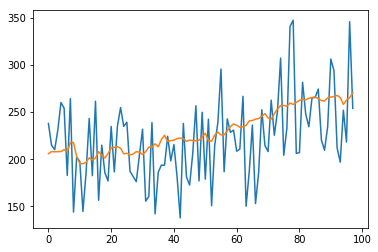

In [42]:
plt.plot(indices,output)
plt.plot(indices,y_test_pred)